## Disaster Pre-positioning with Mathematical Optimization

In this notebook, we will take you through the end-to-end process of how ESUPS transformed from a simple idea into a global initiative that is reshaping disaster response logistics. We will delve into the crucial role that optimization plays in this transformation, demonstrating how ESUPS utilizes advanced algorithms to optimize the allocation and movement of disaster relief supplies.

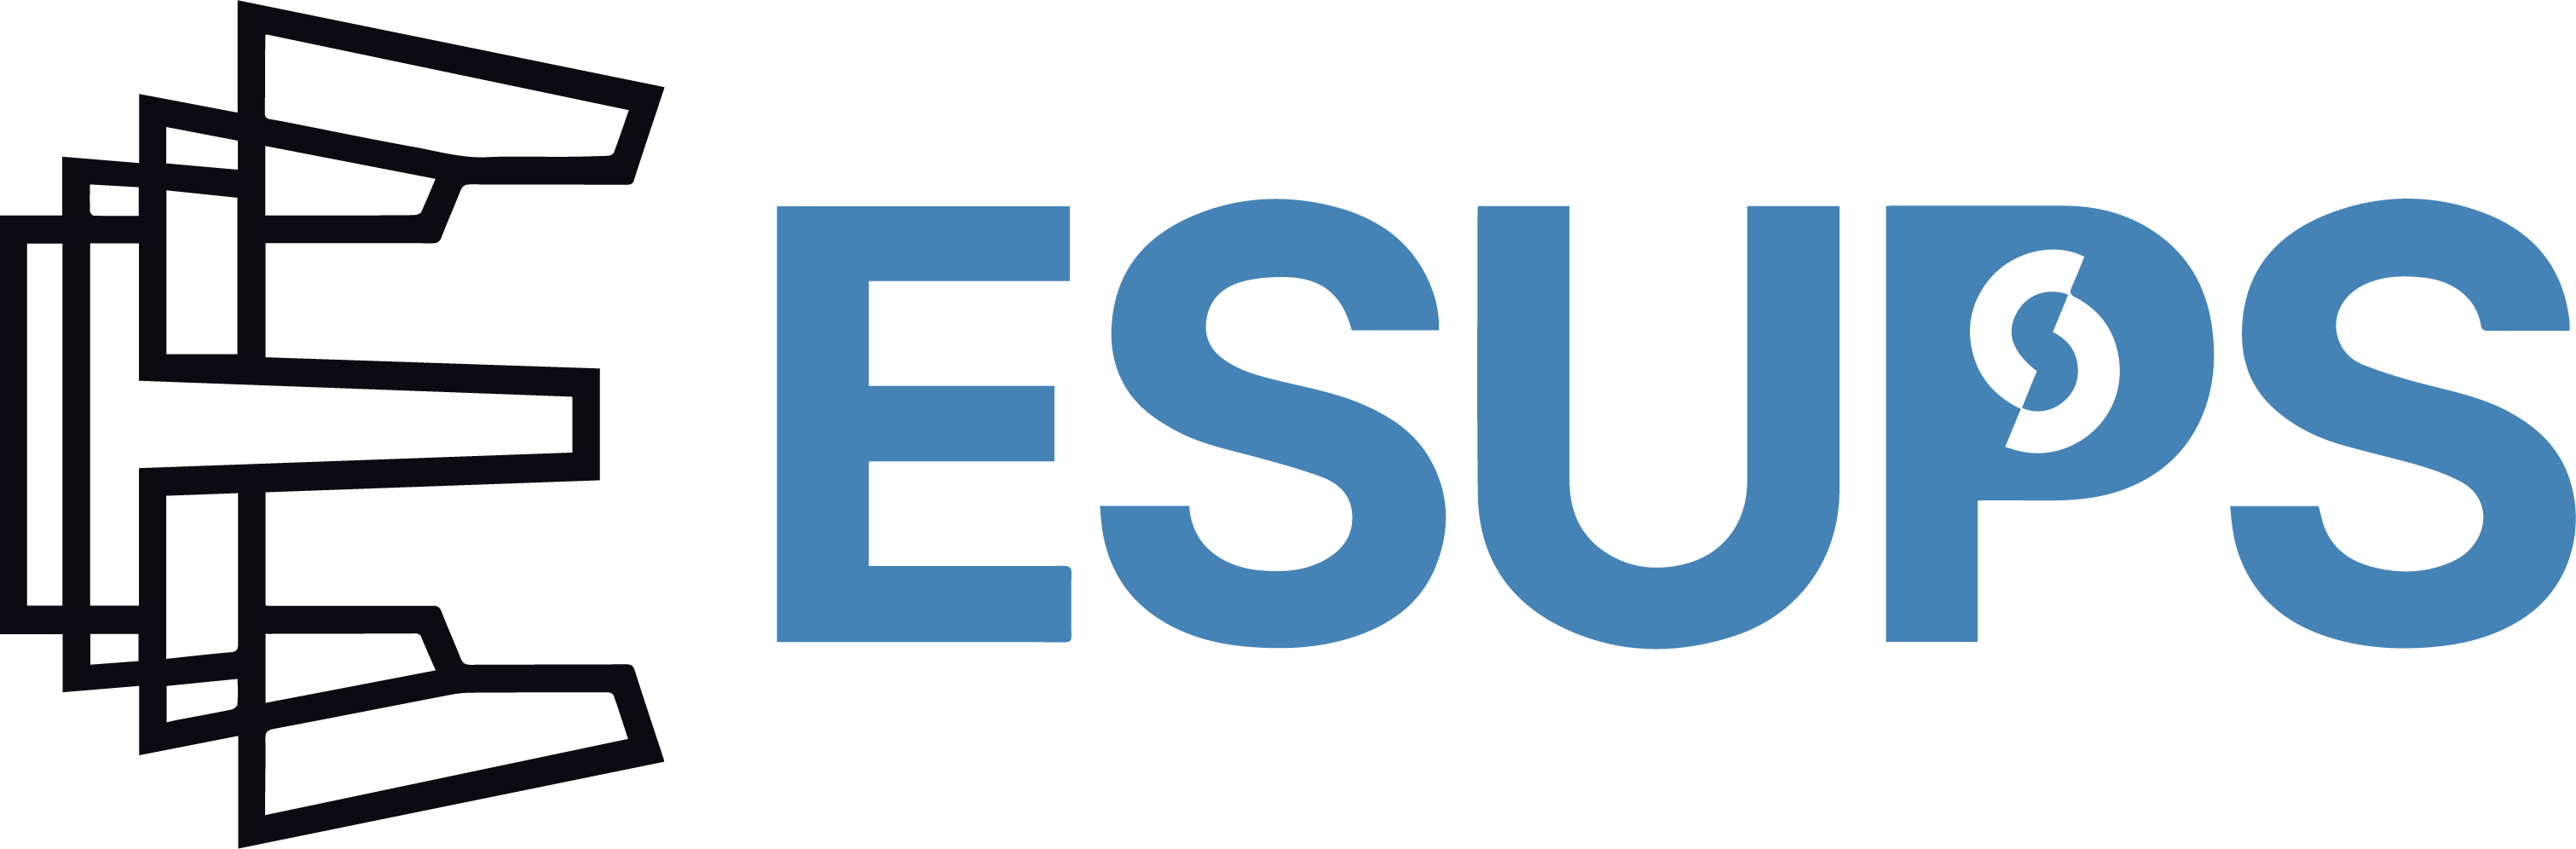

In [1]:
from IPython.display import Image
Image(filename='images/ESUPS-Logo.png', width=600)

## 1. The Setup

Our first step in the journey is reading and cleaning the data. We won't focus too much on this step because the really interesting stuff happens once we have the data loaded. However, we will showcase how the data needs to be formatted for Gurobi. If this is your first pass of the case study, feel free to skip over this section and return to it later when you want a more in-depth overview of formatting the data.

Before we begin, I wanted to make a quick note about a line of code you'll see repeated throughout the notebook: %%script false --no-raise-error


- **NOTE:** This is just cell magic (if you're unfamiliar, think of it as using the cmd line) telling the notebook not to run this cell. We'll use it in various places to demonstrate ideas or code snippets that are not meant to produce an output.

### 1.1 The Environment

There are 4 main libraries we'll be using to solve this problem. The other import statements can be explicitly seen in setup_imports.py, but is primarily for getting all relevant methods from the source repo into our namespace:

In [ ]:
%%capture
%pip install -r requirements.txt              

import pandas as pd
import numpy as np
import math 

import gurobipy as gp
from gurobipy import GRB

#now hidden code
from setup_imports import *

The next and final step in this section is to define what data we'll be using to implement the solver, and in this case, we'll be using real-world data from Madagascar. Madagascar is the fourth largest island in the world and is located off the southeastern coast of Africa. Known for its unique biodiversity, approximately 90% of its wildlife is found nowhere else on Earth. The island's diverse ecosystems range from rainforests to deserts, making it a hotspot for biological research and conservation efforts.

However, Madagascar is also prone to natural disasters, including cyclones, floods, and droughts, all of which have a significant impact on its population and infrastructure. These disasters pose challenges for disaster response and resource allocation, making it an ideal case study for optimization and data-driven decision-making.

In [3]:
#Set Up Our Data
COUNTRY = "madagascar"

### 1.2 Reading and Cleaning 
Now we'll load the data into RAM

In [ ]:
warnings.filterwarnings('ignore') # type: ignore
reader = CsvProblemReader() # type: ignore
dataset = reader.read(DATA_DIR / COUNTRY) # type: ignore

While we won't be focusing on reading in the data, it's always useful to see the general structure. Feel free to skip this part on your first high-level pass and come back to it later when you better understand the details.

You can see in the code below all the factors that go into our model. While intimidating at first glance, this dataset class is a way to tie several related lists and dictionaries to the same name.

In [5]:
%%script false --no-raise-error

#The class is as follows
@dataclass(frozen=True)
class Dataset:
    depots: list[Depot]
    disasters: list[Disaster]
    disaster_locations: list[DisasterLocation]
    probabilities: dict[Disaster, float]
    items: list[Item]
    transport_modes: list[TransportMode]
    inventory: dict[Tuple[Depot, Item], int]
    inventory_scenarios: dict[str, dict[Tuple[Depot, Item], int]]
    distance: DistanceMatrix
    people_affected: dict[Tuple[DisasterImpact, Item], float]
    persons_per_item_general: dict[Tuple[DisasterImpact, Item], float]
    persons_per_item_monthly: dict[Tuple[DisasterImpact, Item], float]
    disaster_affected_totals: dict[str, int]

    _zero_demand_threshold = 1e6


As you can see, the dataset fields are mainly data structures holding other objects. Now we won't go into all these here, but it can be useful to see how they are set up. Let's take a look at one such object. 

In [6]:
%%script false --no-raise-error

@dataclass(frozen=True)
class Item:
    id: str = field(hash=True)
    weight: float = field(repr=False)  # Metric tons
    volume: float = field(repr=False)  # Cubic metres

As you can see, it's a simple data structure, and most of the code here is actually more about organization and readability, which is incredibly useful in production code. Credits here go to Ben Kennerley, who has been working with ESUPS to enhance STOCKHOLM.

### 1.3 Data Exploration and Visualization

It's always useful to see the general structure of data and the broader context of the problem. Now that we've cleaned and loaded it, let's take some time to understand it. The goal here should be to get comfortable with the problem as a whole and give you an intuitive understanding of what we are solving. So, the emphasis isn't on the code. For this reason, most of the following cells have been written as functions to collapse more easily across different platforms. Your goal shouldn't be to understand the libraries used to map, but instead on how Madagascar looks at a high level.

#### 1.3.1 Where is Everything?
One of the first things we'll look at is where the supplies are relative to disasters right now. 

In [ ]:
def graph_locations():
    warehouses = [['warehouses',
                   depot.latitude,
                   depot.longitude] 
                   for depot in dataset.depots]

    disasters = [['disasters',
                  disaster_locations.latitude,
                  disaster_locations.longitude] 
                  for disaster_locations in dataset.disaster_locations]

    dfw = pd.DataFrame(warehouses)
    dfw.columns = ['Type', 'Lat', 'Long']

    dfd = pd.DataFrame(disasters) # type: ignore
    dfd.columns = ['Type', 'Lat', 'Long']

    df_combined = pd.concat([dfw[['Lat', 'Long', 'Type']], dfd[['Lat', 'Long', 'Type']]], ignore_index=True)

    fig = px.scatter_mapbox(df_combined, 
                            lat="Lat", 
                            lon="Long", 
                            color="Type",
                            color_discrete_sequence=px.colors.qualitative.Safe,
                            zoom=4.5)
    
    # Use a minimalist map style to reduce clutter
    fig.update_layout(mapbox_style="open-street-map")

    # Optionally center the map around the mean latitude and longitude of your points
    mean_lat = df_combined['Lat'].mean()
    mean_long = df_combined['Long'].mean()
    fig.update_layout(mapbox_center={"lat": mean_lat, "lon": mean_long})
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})

    fig.show()

graph_locations()

We can see that the warehouses are aligned closely with the most prominent disaster sites*, so assuming they are built to a level that can survive and protect against those disasters, Madagascar should be in a strong position in terms of coverage. However, there's more than meets the eye. Let's dive a little deeper!

Hopefully, now that you've gotten a sense of the country and the layout, we'll turn off some of the more detailed parts (such as roads and urbanization) so it's simpler to see what’s going on.

- **NOTE:** locations of warehouses have been modified for this case study for safety.

#### 1.3.2 What Supplies are Available?

An important question to ask at this point is: what do we have inside the warehouses? It's great that there seems to be good coverage that ensures a warehouse is nearby for any disaster, but if one of them is full of kitchen sets and there's a flood, they might not be as immediately useful as buckets or tarpaulins. So, let's look at the overall breakdown of supplies by warehouse/location:

In [8]:
import plotly.graph_objects as go

# Sample Data
def make_barchart():
    items = {}
    for x in dataset.inventory:
        if x[1].id in items:
            items[x[1].id] += dataset.inventory[x]
        else:
            items[x[1].id] = dataset.inventory[x]

    items = dict(sorted(items.items(), key=lambda item: item[1], reverse=True))

    # Extract keys and values from the dictionary
    categories = list(items.keys())
    values = list(items.values())

    # Normalize the values for color scale
    normalized_values = np.array(values) / max(values)

    # Define a color scale (e.g., 'Viridis', 'Cividis', 'Plasma', etc.)
    colorscale = 'Cividis'

    def format_number(num):
        if num >= 1_000_000:
            return f'{num/1_000_000:.1f}M'  # Format as millions
        elif num >= 1_000:
            return f'{num/1_000:.0f}k'  # Format as thousands
        else:
            return str(num)  # Show the number as is if below 1,000

    # Create formatted text for display
    formatted_text = [format_number(v) for v in values]  # Use the custom formatting function

    # Create a bar chart with a color continuum
    fig = go.Figure(
        data=[
            go.Bar(
                x=categories,
                y=values,
                marker=dict(
                    color=normalized_values,  # Use normalized values for the color scale
                    colorscale=colorscale,  # Apply the chosen color scale
                    showscale=False  # Hide the color scale bar
                    
                ),
                texttemplate='%{text}',  # Explicitly set text template
                text=formatted_text,  # Display formatted text with 'k' and 'M' suffixes
                hovertemplate='<b>%{x}</b><br>Quantity: %{y}<extra></extra>',  # Show exact hover info
                textposition='auto',  # Automatically position the text
            )
        ]
    )

    # Update layout
    fig.update_layout(
        title={
            'text': "Distribution of Supplies for Disaster Relief",
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title="Supplies",
        yaxis_title="Quantity",
        yaxis_type="log",  # Logarithmic scale for better visualization
        xaxis=dict(tickangle=-45),  # Rotate x-axis labels for better readability
        plot_bgcolor='white',  # Set background color to white for better contrast
        xaxis_tickfont_size=10,  # Font size for x-axis labels
        yaxis_tickfont_size=10,  # Font size for y-axis labels
        margin=dict(l=40, r=40, t=80, b=100),  # Adjust margins
    )

    # Add annotations to highlight key insights
    fig.add_annotation(
        x=categories[0],  # Example: Highlighting the highest value category
        y=values[0],
        text="Highest Quantity",
        showarrow=True,
        arrowhead=2,
        ax=-40,
        ay=-40
    )

    # Show the plot
    fig.show()

make_barchart()

As we can see from above, the supplies skew heavily towards buckets, water containers, and mosquito nets, which makes sense for an island nation. But while it's great that we have a lot of buckets, it won't do us too much good if none of them are at the coast, for instance.

- **NOTE:** From here on out in the case study, we're going to focus on just buckets as they're the most prevalent item and, for the purposes of this case, it's time consuming and repetitive to analyze all 15 item types of supplies available. 

As you'll see later in the notebook, it's a simple matter to apply the analysis of any one of the supply items to all 15 of them.

#### 1.3.4 Where are the Supplies?

Let's take a look at the following map to get a better picture of where everything is.

In [9]:
def graph_supplies():
  supplies=[[x[0].latitude,
             x[0].longitude,
             dataset.inventory[x]]
             for x in dataset.inventory if x[1].id=='Buckets']
 
  df=pd.DataFrame(supplies)
  df.columns = ['Lat', 'Long', 'Buckets']

  fig = px.scatter_mapbox(df, 
                        lat="Lat", 
                        lon="Long", 
                        size="Buckets",
                        #size_max=10,  # Maximum size of the marker
                        #size_min=5,
                        color_discrete_sequence=px.colors.qualitative.Safe,
                        zoom=4.5,  # Adjust zoom level as needed
                        )

  # Optionally center the map around the mean latitude and longitude of your points
  # Use a minimalist map style to reduce clutter
  fig.update_layout(mapbox_style="carto-positron")

  mean_lat = df['Lat'].mean()
  mean_long = df['Long'].mean()
  fig.update_layout(mapbox_center={"lat": mean_lat, "lon": mean_long})
  fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

  fig.show()
graph_supplies()

We can see that the supplies are largely located on the eastern coastline of the country.

#### 1.3.5 Not All Disasters Are Built the Same

In [10]:
def graph_impacts():
    
    # Example values for l and h
    l = -0.1
    h = 0.1

    # Sample data preparation
    disasters = [[disasters.type.id,
                disaster_locations.latitude,
                disaster_locations.longitude,
                dataset.disaster_affected_totals[key]] 
                for disasters, disaster_locations, key in zip(dataset.disasters, dataset.disaster_locations, dataset.disaster_affected_totals)]

    df = pd.DataFrame(disasters)
    df.columns = ['Type', 'Lat', 'Long', 'People Impacted']

    fig = px.scatter_mapbox(df, 
                            lat="Lat", 
                            lon="Long", 
                            color="Type", 
                            size="People Impacted",
                            #size_max=10,  # Maximum size of the marker
                            #size_min=5,
                            zoom=4.5,  # Adjust zoom level as needed
                            color_discrete_sequence=px.colors.qualitative.Safe,
                            )

    # Optionally center the map around the mean latitude and longitude of your points
    # Use a minimalist map style to reduce clutter
    fig.update_layout(mapbox_style="carto-positron")

    mean_lat = df['Lat'].mean()
    mean_long = df['Long'].mean()
    fig.update_layout(mapbox_center={"lat": mean_lat, "lon": mean_long})
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

    fig.show()

graph_impacts()

#### 1.3.6 How Do Disasters and Supplies Compare in Scale?

You can see small blue circles within the red circles, representing supply quantities. The size of each red circle indicates the estimated number of people needing supplies in a disaster-affected area. Meanwhile, the blue circles show the total number of items available, adjusted by how many people each item can serve. For example, one large bucket is estimated to meet the needs of 2.5 people, so the blue circles display the quantity of supplies as $2.5 \cdot Supplies$


In [11]:
def graph_overlap():
  supplies=[['supplies',
             x[0].latitude,
             x[0].longitude,
             dataset.inventory[x]*2.5] #this is people per bucket
             for x in dataset.inventory if x[1].id=='Buckets']
 
  supplies=pd.DataFrame(supplies)
  supplies.columns = ['Type','Lat', 'Long', 'Scale']


  # Sample data preparation
  disasters = [['disasters',
                disaster_locations.latitude,
                disaster_locations.longitude,
                dataset.disaster_affected_totals[key]] 
                for disasters, disaster_locations, key in zip(dataset.disasters, dataset.disaster_locations, dataset.disaster_affected_totals)]

  disasters = pd.DataFrame(disasters)
  
  
  disasters.columns = ['Type', 'Lat', 'Long', 'Scale']

  df_combined = pd.concat([supplies[['Type','Lat', 'Long', 'Scale']],
                           disasters[['Type','Lat', 'Long', 'Scale']]],
                           ignore_index=True)




  fig = px.scatter_mapbox(df_combined, 
                        lat="Lat", 
                        lon="Long", 
                        size="Scale",
                        color='Type',
                        size_max=40,  # Maximum size of the marker
                        #size_min=5,
                        zoom=4.5,  # Adjust zoom level as needed
                        color_discrete_sequence=px.colors.qualitative.Safe,
                        )

  # Optionally center the map around the mean latitude and longitude of your points
  # Use a minimalist map style to reduce clutter
  fig.update_layout(mapbox_style="carto-positron")

  mean_lat = df_combined['Lat'].mean()
  mean_long = df_combined['Long'].mean()
  fig.update_layout(mapbox_center={"lat": mean_lat, "lon": mean_long})
  fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

  fig.show()

graph_overlap()

### 1.4 How Does ESUPS Communicate this?


ESUPS' platform  [Stockholm](https://www.esups-stockholm.org/#/private/signin), which is hosting this model (you can apply for access by visiting the homepage linked above), has two main pages, the first is the context page, and explains the context of the problem that we've been discussing in the past few sections, along with additional details about their mission and collaborating organizations. We'll look at this one first!

**The Real-time Data Visualization** : Progressive Improvement

We're going to take a slight detour here to look at how all this information is communicated in real life! You can skip this section without concern for missing important information. 

As we've seen, getting an intuitive understanding of disasters and humanitarian supplies can be tricky when working with a new country. In fact, it's one of the main challenges ESUPS has faced in driving adoption and explaining why their work is so important. 

Data Visualization isn't an easy task, but let's take a look at how ESUPS started and how they're continuing to improve!

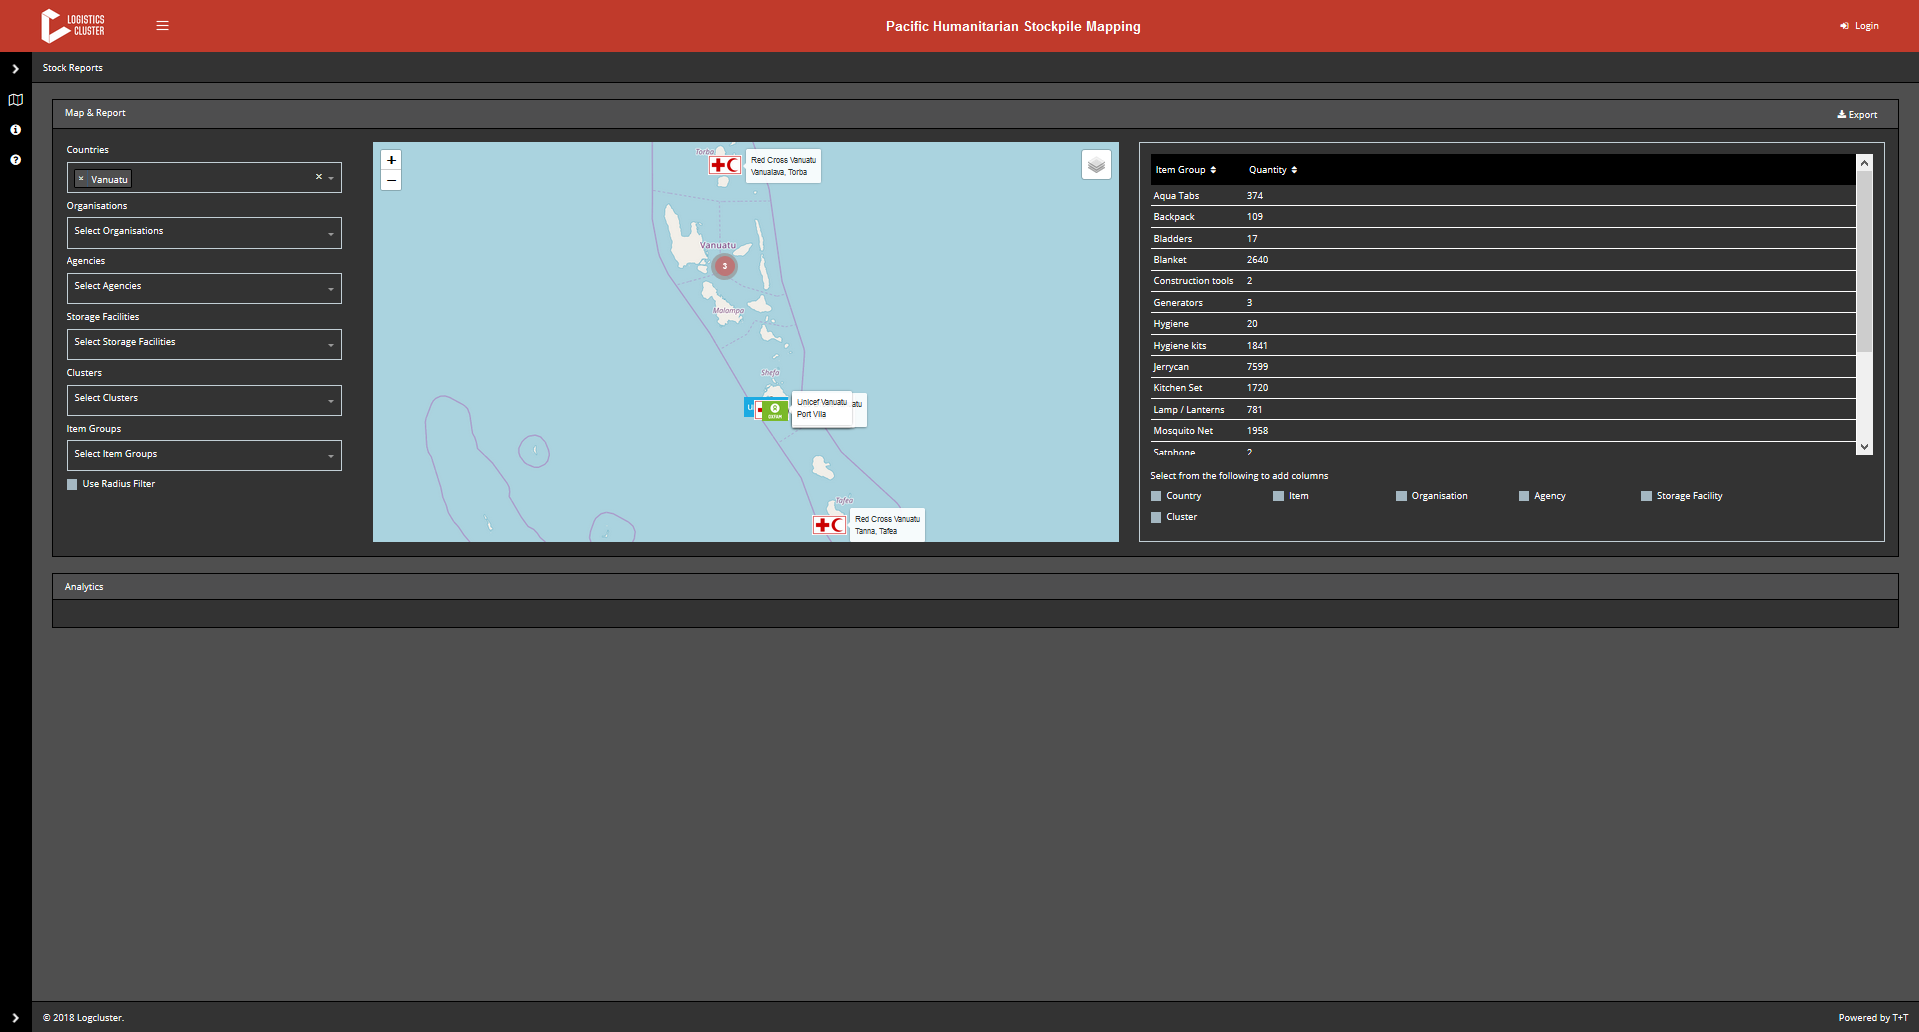

In [12]:
Image(filename='images/Old_Stockholm.png', width=1200)

Here is one of the earlier versions of the ESUPS dashboard; even in v1, it played a critical role in enabling the organization to quickly deliver a functional product that demonstrated tangible results to other non-profits. This initial version provided the essential tools needed to map stockpiles and showcase the value of the platform in real-world scenarios. By prioritizing functionality and speed, ESUPS was able to meet the immediate needs of its partners, proving the concept and gaining crucial buy-in from stakeholders.

The lesson here: Start with the tools and skills available and always look for ways to improve. 

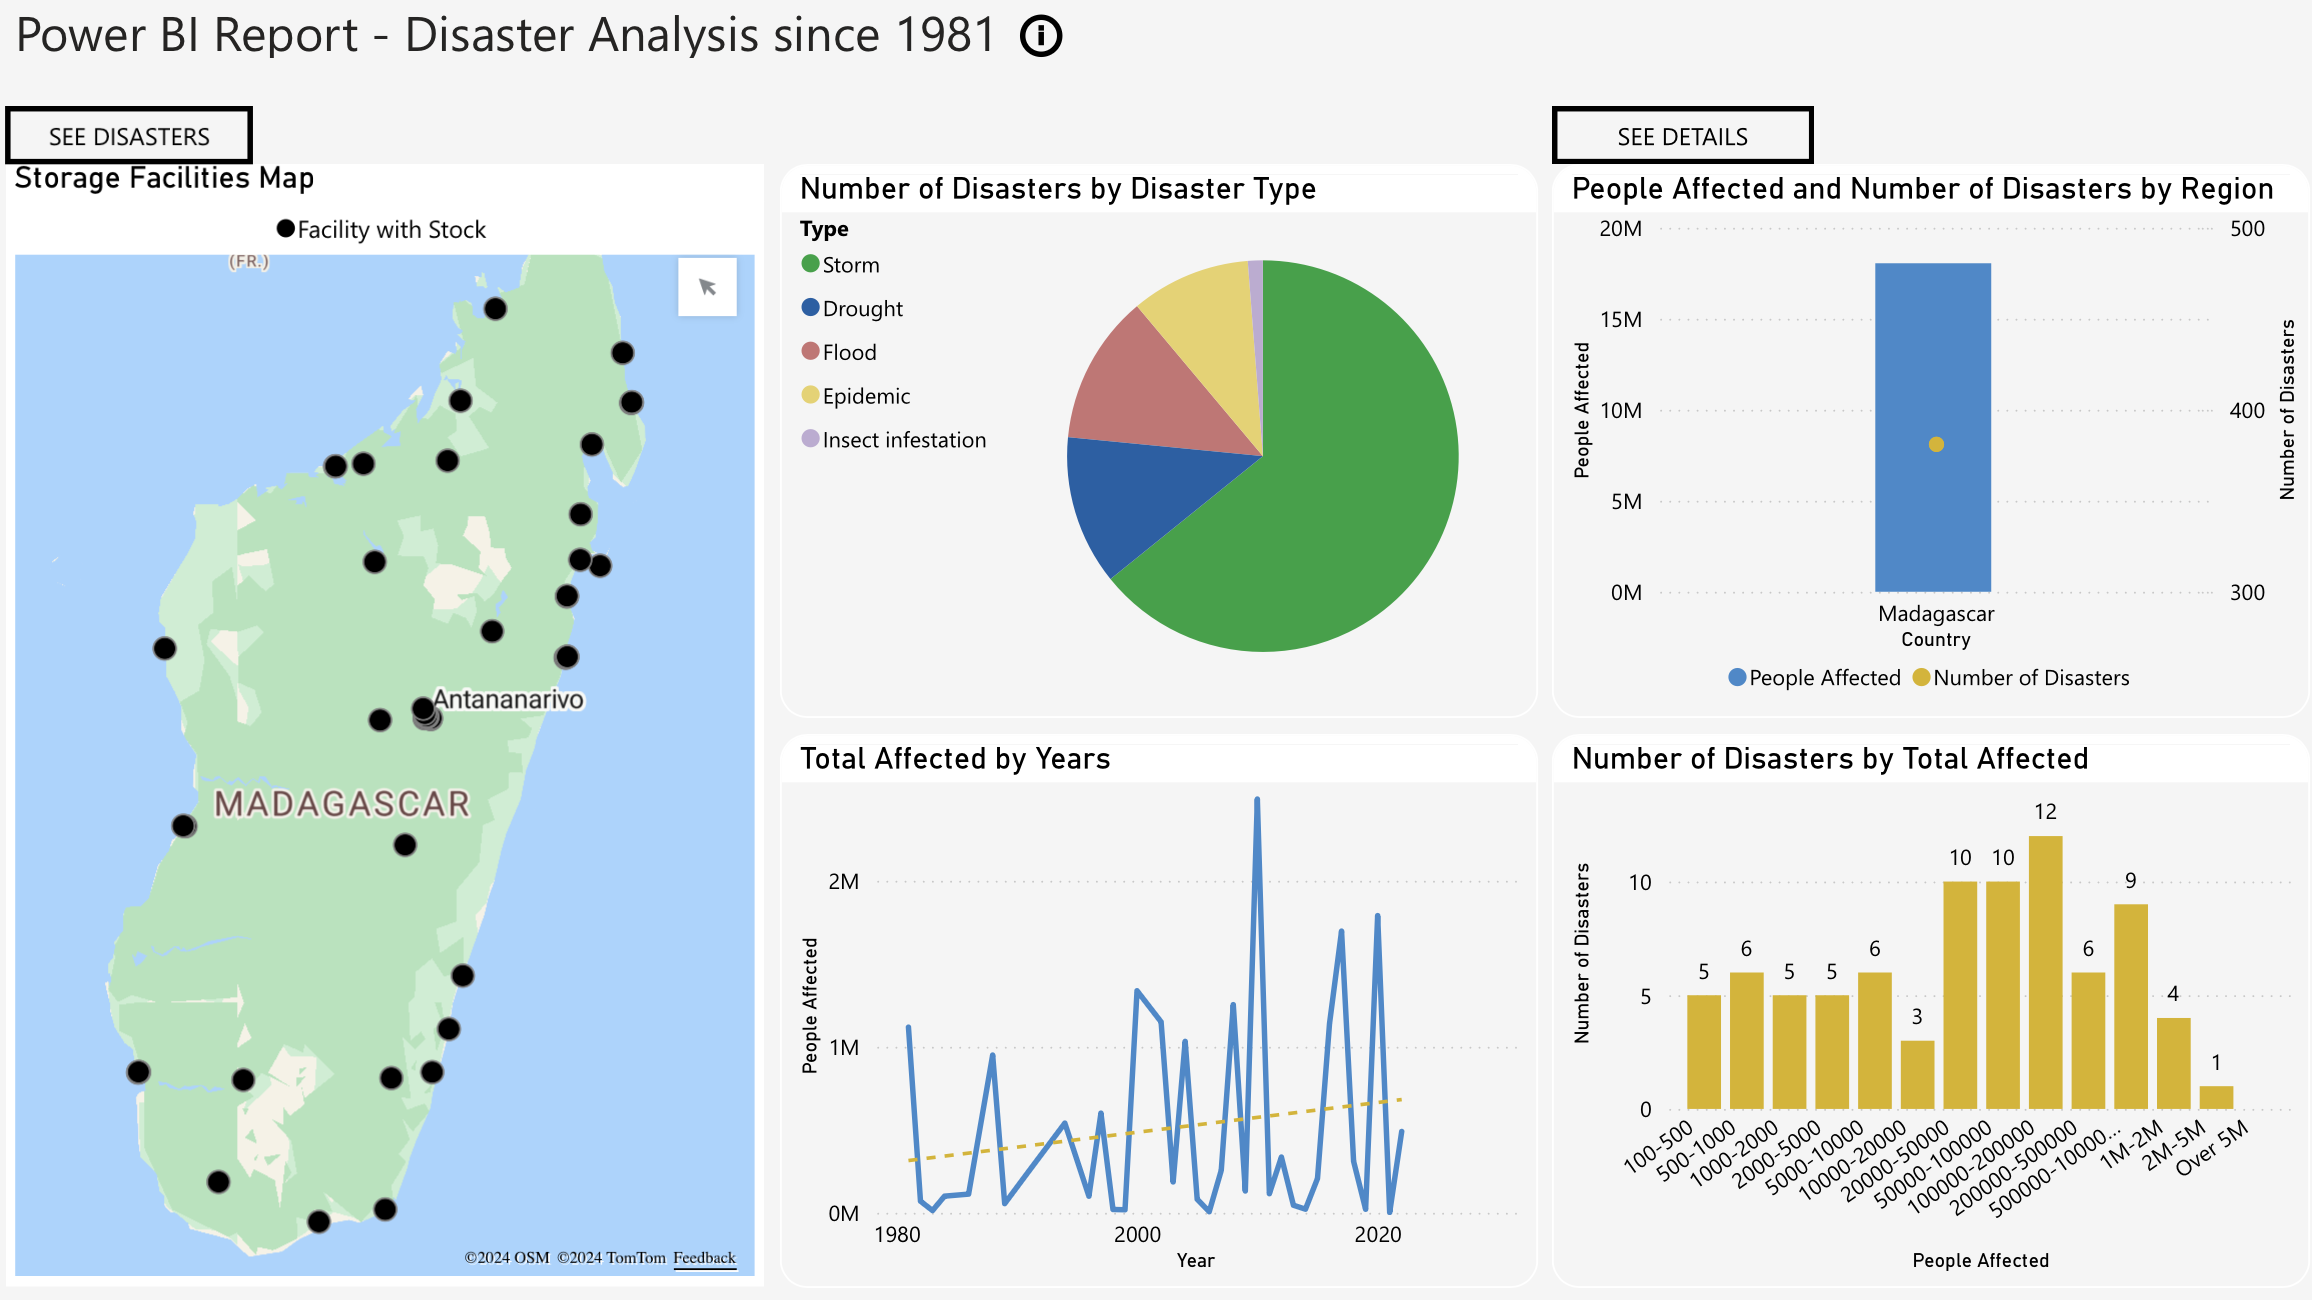

In [13]:
Image(filename='images/Disaster_Dashboard.png',width=1200)

## 2. Optimizing!



### 2.1 Intro to the ESUPS Optimization Model

Let:

- $\tau_{ij}$ be the time to ship a single item from warehouse $i$ to the disaster

- $y_i$ be the amount of supplies to send from warehouse $i$ to our disaster

- $x_i$ be the starting inventory at each warehouse

- $d$ be the demand for an item


Now that we have described what we can change with our variables, we can figure out how to represent the objective function!
$$
\min_y \sum_i \tau_{i}\cdot y_i
$$

The constraints are:

$$
\begin{aligned}
\text{s.t.}  & \sum_{i} & y_{i}&=d & & \hspace{.2cm} \text{(total supplies sent must meet demand)}\\

& & y_i       &\leq x_i & \forall i \in I& \hspace{.2cm}\text{(you can't send more than a warehouse has)}\\

 &\text{} & y_{i} &\geq 0 &\forall i \in I& \hspace{.2cm} \text{(you can't send negative supplies)}
\end{aligned}
$$

<div class="alert alert-warning">
    <strong>Note!</strong>
    <p>Decision variables in mathematical optimization problems are typically assumed to be nonnegative. So while you'll see these constraints in formulations (i.e. the algebraic representations), you may not see the code for it since it's likely assumed to be nonnegative.</p>
</div>

So now let's solve this model. 

##### Create The Model Object

In [ ]:
#prep distance matrix
df_distance, relevant_warehouses, BucketsNeeded = get_distance_matrix(dataset) # type: ignore
t = df_distance.drivingTime_hrs
n = len(relevant_warehouses)

# Create model
model = gp.Model("simple_Allocation") 

# Add decision variables
y=model.addVars(n, name="Warehouse_Allocation")

#Add constraint to meet demand
model.addConstr(gp.quicksum(y[i] for i in range(n))==BucketsNeeded,name='Meet_Demand')

# Add in warehouse_constraints
for i, supplies in enumerate(relevant_warehouses):
    model.addConstr(y[i] <= supplies[2], name=f"warehouse_endowment_{i}")

# Note we don't have a constraint for y >= 0 since it's assumed in the variable definition
# Add objective
objective = gp.quicksum(t[i] * y[i] for i in range(n))
model.setObjective(objective, GRB.MINIMIZE)


Restricted license - for non-production use only - expires 2025-11-24


In [15]:
# Fire up the solver!
model.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[rosetta2] - Darwin 24.1.0 24B83)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17 rows, 16 columns and 32 nonzeros
Model fingerprint: 0x37d66425
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+04]
Presolve removed 16 rows and 2 columns
Presolve time: 0.01s
Presolved: 1 rows, 14 columns, 14 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.691875e+03   0.000000e+00      0s
       1    9.8293000e+04   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.829300000e+04


Now let's analyze the results!

In [16]:
#Show Solution
b=[]
for v, total, dis in zip(model.getVars(),relevant_warehouses,list(df_distance['drivingTime_hrs'])):
    if v.VarName[0:20]== 'Warehouse_Allocation':
        #print('%s %g | total= %g | distance=%g' % (v.VarName, v.X,total[2],dis))
        b.append([v.VarName, v.X,total[2],dis])
b=pd.DataFrame(b)
b.columns=['Var','amount','possible','distance']
b.sort_values('distance')

,Var,amount,possible,distance
1,Warehouse_Allocation[1],26.0,26,0.00
4,Warehouse_Allocation[4],9046.0,9046,6.00
11,Warehouse_Allocation[11],3.0,3,7.00
14,Warehouse_Allocation[14],1580.0,1580,8.00
5,Warehouse_Allocation[5],610.0,610,10.00
2,Warehouse_Allocation[2],0.0,41,11.00
7,Warehouse_Allocation[7],2296.0,6689,11.00
0,Warehouse_Allocation[0],0.0,375,14.00
9,Warehouse_Allocation[9],0.0,2460,14.25
8,Warehouse_Allocation[8],0.0,150,16.00


Now you may have noticed that this feels like overkill. If we want to position supplies to respond to a known disaster, you might think that we should just put them as close as possible. It's an intuitive solution that can be solved with a simple greedy algorithm. But of course, life is never that simple. 

Now that we've got the initial problem outlined, let's start making it more realistic with two additions:
1.	Instead of preparing for only one disaster, let's prepare for all the disasters that might occur.
2.	Instead of being an omniscient observer, let's say we aren't sure where the next disaster will be.

### 2.2 Including All Disasters

Before we begin, let's explicitly define our new problem with the additional requirements outlined in the previous section so we're all on the same page. Our first step is to add in the fact that there are more disasters than just one. We can do that by including a variable to denote which disaster we're talking about.

Let:

- $k$ be the disaster scenario at hand i.e. a storm, earthquake, or epidemic
- $j$ be the location of the disaster

In scenario $k$ with the disaster located at $j$, the time for a warehouse $i$  to send $y_i$ items is: 

 $$\tau_{ij}\cdot y^k_i$$

Repeating for all warehouses gives us

$$  \sum_i \tau_{ij}\cdot y^k_i $$


Repeating for all disasters gives us

$$ \sum_k \sum_i \tau_{ij}\cdot y^k_i $$


This formulation doesn't change any of the solutions we found in the last section, instead, it's leveraging the power of our notation to be able to solve for the optimal allocation for every disaster in one fell swoop! It's been a while since we looked at the original problem in its entirety, so let's take a step back to understand why this is so important.

Before we get to solving, let's add in one more small factor. Different disasters occur at different rates. A landlocked nation may be less likely to experience a disaster caused by a tropical storm than an earthquake, so shouldn't we weigh the response time to earthquakes more than that of a storm?

### 2.3 Accounting for Randomness

One of the most difficult tasks that we can encounter in data science problems is randomness or as it's often called "stochastic" elements. This can be seen in all kinds of ways, but in our case study, we're going to look at how we account for not knowing which disaster will hit next or even several years in the future. The way we do this is to create a stochastic model, which may initially seem intimidating, but in discrete events like this, it's super easy.

If you're familiar with expected value this will quickly make sense, but no need to have any prior experience! The idea is that we weigh the outcome of the event (i.e. total travel time in this case) by the probability it occurs. So, if an earthquake is 3 times as likely as a flood, we would rewrite the equation as:

$$.75 \cdot\text{(travel time earthquake)} + .25 \cdot\text{(travel time flood)} $$


#### 2.3.1 More On Expected Value

If you haven't seen expected value before or if it's just been a while and you'd like a refresher, try some of the practice problems below!

When we solve expected value for discrete outcomes, we take the value/outcome/payoff of each possible event and discount it by the probability that it actually occurs. So it follows the form:

$$
E[X]=p_1(x_1)+p_2(x_2)+ ... + p_n(x_n)
$$
To simplify this notation we typically write this as a series:

$$
E[X]=\sum_{i=1}^{i=n} p_i \cdot x_i
$$

**Starter Problems**

##### Simple Dice Game:


Suppose you roll a fair six-sided die. If it lands on 6, you win $10; otherwise, you lose $2. What is the expected value of this game? Should you play it?

##### Solution


$$
\begin{aligned}
E[X] &= \left(\frac{1}{6} \times 10\right) + \left(\frac{5}{6} \times (-2)\right)
\\
E[X] &= \left(\frac{10}{6}\right) + \left(\frac{-10}{6}\right)
\\
E[X] &= \frac{10 - 10}{6} = 0
\end{aligned}
$$
**Answer**: The expected value is $\$0$. This means, on average, you neither gain nor lose money from playing this game.


##### Two-Coin Game:


You flip two fair coins. If both coins land on heads, you win $8. If one coin lands on heads and the other on tails, you win $4. If both coins land on tails, you lose $5. What is the expected value of playing this game?


##### Solution:


- Probability of two heads (HH): $\frac{1}{4}$
- Probability of one head and one tail (HT or TH): $\frac{1}{2}$
- Probability of two tails (TT): $\frac{1}{4}$

$$
\begin{aligned}
E[X] &= \left(\frac{1}{4} \times 8\right) + \left(\frac{1}{2} \times 4\right) + \left(\frac{1}{4} \times (-5)\right)
\\
E[X] &= \left(2\right) + \left(2\right) + \left(-1.25\right)
\\
E[X] &= 2 + 2 - 1.25 = 2.75

\end{aligned}
$$
**Answer**: The expected value is $\$2.75$. This means, on average, you gain $\$2.75$ per game.


##### Intermediate Problems

**Card Drawing Game:**
You draw a card from a standard deck of 52 playing cards. If you draw an Ace, you win $15. If you draw a King, Queen, or Jack, you win $5. For any other card, you lose $3. What is the expected value of this game?

##### Solution:

- Probability of drawing an Ace: $\frac{4}{52} = \frac{1}{13}$
- Probability of drawing a King, Queen, or Jack: $\frac{12}{52} = \frac{3}{13}$
- Probability of drawing any other card: $\frac{36}{52} = \frac{9}{13}$

$$
\begin{aligned}

E[X] &= \left(\frac{1}{13} \times 15\right) + \left(\frac{3}{13} \times 5\right) + \left(\frac{9}{13} \times (-3)\right)
\\


E[X] &= \left(\frac{15}{13}\right) + \left(\frac{15}{13}\right) + \left(\frac{-27}{13}\right)
\\


E[X] &= \frac{15 + 15 - 27}{13} = \frac{3}{13}

\\
E[X] &\approx 0.23

\end{aligned}
$$

**Answer**: The expected value is approximately \$0.23. On average, you gain 23 cents per draw.


#### 2.3.2 The Model

Let $P^k$ be the probability of disaster $k$ and $t^k$ be the total travel time involved in disaster $k$ in the previous sections. Using our definition of expected value, this gives us:

$$ \sum_k P^k \cdot t^k$$

Now you might notice that we have already written an equation for the total travel time for disaster $k$ ! Substituting this in we get:

$$\sum_k P^k \sum_i \tau_{ij}\cdot y^k_i$$

So, our final task right now is to minimize the time required to get supplies to a disaster given how likely each disaster is to occur:


$$
\min_y \sum_k P^k \sum_i \tau_{ij}\cdot y^k_i

$$

And we can see the constraints are almost unchanged. The only added part is that all probabilities must sum to one, which is always the case:
$$
\begin{aligned}


\text{s.t.}  & \sum_{i} & y^k_{i}&=d^k & & \hspace{.2cm} \text{(total supplies sent must meet demand)}\\

& & y^k_i       &\leq x_i & \forall i \in I& \hspace{.2cm}\text{(you can't send more than a warehouse has)}\\

 &\text{} & y^k_{i} &\geq 0 &\forall i \in I& \hspace{.2cm} \text{(you can't send negative supplies)}\\


\end{aligned}
$$

How do we calculate the probability though? Well, we have good long-term data on what disasters have affected which countries. For now, we can go through that data and calculate the probability of disaster k by counting how many times it has occurred and dividing by the number of total disasters:

$$ P^k = \frac{k}{\|K\|}$$

So now that we have the equation, we can let the model go ahead and let Gurobi solve it for us.

In [19]:
demand, probs = get_probs(dataset)

n = len(relevant_warehouses)
m = len(demand)
a = []

model = gp.Model("all_disaster_allocation") 

# Create an array of driving times based on the df_distance DataFrame
t = df_distance.drivingTime_hrs
c = pd.DataFrame(t)

# Amount to take per Warehouse
y = model.addVars(m, n, name="Warehouse_Allocation")

# Add constraints to meet demand for each disaster scenario (k)
for k in range(m):
    # Demand constraints
    model.addConstr(gp.quicksum(y[k, i] for i in range(n)) == demand[k], name=f"Meet_Demand_K:{k}")
    
    # Warehouse constraints
    for i, supplies in enumerate(relevant_warehouses):
        model.addConstr(y[k, i] <= supplies[2], name=f"warehouse_endowment_K:{k}_I:{i}")

# Objective function to minimize the weighted driving time using T as a parameter
objective = gp.quicksum(
    probs[k] * gp.quicksum(t[i] * y[k, i] for i in range(n))
    for k in range(m)
)

# Optimize model
model.setObjective(objective, GRB.MINIMIZE)
model.optimize()

# Store results in the list 'a'
for v in model.getVars():
    a.append([v.VarName, v.X])

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[rosetta2] - Darwin 24.1.0 24B83)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1088 rows, 1024 columns and 2048 nonzeros
Model fingerprint: 0xd98f621f
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-02, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 4e+04]
Presolve removed 1079 rows and 899 columns
Presolve time: 0.01s
Presolved: 9 rows, 125 columns, 125 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9962728e+05   2.378912e+04   0.000000e+00      0s
       9    3.2740300e+05   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.274030000e+05


In [20]:
pd.DataFrame(a).iloc[:15]

,0,1
0,"Warehouse_Allocation[0,0]",375.0
1,"Warehouse_Allocation[0,1]",26.0
2,"Warehouse_Allocation[0,2]",41.0
3,"Warehouse_Allocation[0,3]",2322.0
4,"Warehouse_Allocation[0,4]",9046.0
5,"Warehouse_Allocation[0,5]",610.0
6,"Warehouse_Allocation[0,6]",5201.0
7,"Warehouse_Allocation[0,7]",6689.0
8,"Warehouse_Allocation[0,8]",150.0
9,"Warehouse_Allocation[0,9]",2460.0


### 2.5 Data Science Extension

We've seen how the equation uses the uniform distribution to solve the problem, but what if we knew something it didn't? What if knowing that climate change is increasingly energizing large storms, we decide the past hurricane impacts aren't representative of what's to come? In this section we want to prompt you to come up with predictive elements to improve our models. Feel free to use some of the ideas below or go in an entirely new direction!

In this section, we encourage you to think creatively about enhancing predictive models for climate-related disasters. Consider how to incorporate novel data sources, feature engineering techniques, and model architectures to improve predictions. Below are some suggested approaches, but feel free to explore entirely new directions!

Case Study Focus: Coastal Eastern African Nations

Using the disaster impact data for coastal Eastern African nations, can you develop a model to predict how these impacts might escalate for Madagascar in the coming years? Consider not only the historical data but also factors such as changes in sea surface temperatures, shifting storm tracks, population growth along vulnerable coastlines, and evolving infrastructure resilience. Further, can you integrate this predictive model into an optimization framework to better allocate resources for disaster preparedness and response?

Potential Approaches to Explore:
1. **Comparing Time Series Models:** Traditional statistical time series models like ARIMAX (AutoRegressive Integrated Moving Average with Explanatory Variables) are commonly used to predict future values based on past data. How do these models compare with more advanced Recurrent Neural Network (RNN)-based approaches like Long Short-Term Memory (LSTM) networks or Gated Recurrent Units (GRUs) in capturing long-term dependencies, especially under non-stationary conditions induced by climate change?

2.	**Incorporating Geospatial Data:** Geospatial features, such as latitude, longitude, elevation, and proximity to bodies of water, can play a crucial role in predicting the impact of tropical storms. Can we encode geospatial information using techniques like convolutional neural networks (CNNs) for spatial feature extraction, or leverage more specialized models such as Geographical Weighted Regression (GWR) or Graph Neural Networks (GNNs) to account for spatial dependencies?

3.	**Incorporating Climate Change Projections:** Beyond just historical data, consider how future climate projections can be integrated into the model. Can we use downscaled climate model outputs or ensemble approaches to account for different climate scenarios? How would these scenarios affect the frequency and intensity of tropical storms affecting coastal Eastern African nations?

4.	**Feature Engineering with Climate Indicators:** Introduce climate change indicators as predictive features. For example, how do trends in sea surface temperatures (SSTs), El Niño-Southern Oscillation (ENSO) phases, or the Atlantic Multi-decadal Oscillation (AMO) correlate with storm intensification? Would incorporating these indicators as additional time series variables enhance predictive accuracy?
	
5.	**Hybrid and Ensemble Models:** Can we leverage hybrid models that combine both statistical and deep learning approaches, or use ensemble methods that aggregate predictions from multiple models? For example, combining ARIMAX for short-term predictions with LSTM for capturing long-term trends may provide a more comprehensive forecasting tool.

6.	**Optimization Integration:** Once a reliable predictive model is established, how can it be integrated into an optimization framework for resource allocation? For example, can we build an optimization model that minimizes both the cost of disaster preparedness and the potential loss from future storm impacts?

7.	**Model Explainability and Decision-Making:** How can we ensure that the model is interpretable for decision-makers? Consider the use of techniques like SHAP (SHapley Additive exPlanations) values or LIME (Local Interpretable Model-agnostic Explanations) to explain which factors contribute most to the model’s predictions, helping policymakers make informed decisions.

By combining predictive analytics with optimization, we can not only forecast future disaster impacts but also develop actionable strategies for minimizing those impacts. The goal is to make our models both more accurate and more useful in real-world applications, driving better outcomes for communities at risk.


### 2.6 Putting it All Together: Optimizing Allocation and Transportation

Great, now that we can solve for the time it takes to address every single disaster, we can finally answer the original question posed: how do we best allocate supplies to all the warehouses? The key here is to create a second optimization problem. Remember how in our constraints we included that you can't send more than the warehouse has? 

$$
y^k_i       \leq x_i,\space  \forall i \in I \hspace{.2cm}\text{(you can't send more than a warehouse has)}\\
$$

So far, we've just been using the actual allocation we have at each warehouse for $x_i$. But what if those change? Suddenly we would have an entirely new solution. So, if we say that the output of Gurobi (i.e. the allocations $y^k_i \in Y$) is some function based on our starting amount of warehouses ($X$ where $x_i\in X$), then we can say:

$$Y=f(X)$$ 

And when we frame it this way, it becomes much more simple to solve! All we need to do is minimize the travel times $Y$. In other words, our problem becomes: 


$$ \min_{X} f(X) $$
$$\begin{aligned}
\text{s.t.}  & \sum_{i} & x_i&=\chi & & \hspace{.2cm} \text{(we allocate all supplies and no more)}\\

 && x_{i} &\geq 0 &\forall i \in I& \hspace{.2cm} \text{(you can't allocate negative supplies)}\\

\end{aligned}$$

Where $\chi$ is the total amount of supplies we have in the country



While this may initially look intimidating, it is one of the easiest changes to make to our current code. All we are doing is making a decision variable instead of a constant and then constraining it. Let’s substitute back in our equation from the last section the new constraints to see this firsthand. To denote a new decision variable (i.e. a variable that can be changed), all we need to do is add it under the minimization sign. This means minimizing with respect to $x$ and $y$:

$$
\min_{x,y} \sum_k P^k \sum_i \tau_{ij}\cdot y^k_i
$$

Then all we need to do is update the constraints. I've included the line to make it easier to see what's new as our list grows. It has no mathematical significance. 

So how do we implement this in Gurobi?

$$
\begin{aligned}


\text{s.t.}  & \sum_{i} & y^k_{i}&=d^k & & \hspace{.2cm} \text{(total supplies sent must meet demand)}\\

& & y^k_i       &\leq x_i & \forall i \in I& \hspace{.2cm}\text{(you can't send more than a warehouse has)}\\

 &\text{} & y^k_{i} &\geq 0 &\forall i \in I& \hspace{.2cm} \text{(you can't send negative supplies)}\\
\hline \\
  & \sum_{i} & x_i&=\chi & & \hspace{.2cm} \text{(we allocate all supplies and no more)}\\

 && x_{i} &\geq 0 &\forall i \in I& \hspace{.2cm} \text{(you can't allocate negative supplies)}\\


\end{aligned}
$$



So how do we Implment this in Gurobi?

In [21]:
model = gp.Model("full_allocation")

n = len(relevant_warehouses)
m = len(demand)

# Create an array of driving times based on the df_distance DataFrame
t = df_distance.drivingTime_hrs

# Amount to take per Warehouse
y = model.addVars(m, n, name="Single_Warehouse_Allocation")

# National Allocation
X = model.addVars(n, name="National_Allocation")

# Total national endowment constraint
model.addConstr(gp.quicksum(X[i] for i in range(n)) == 40811, name="Total_National_Endowment")

for k in range(m):
    model.addConstr(y[k, i] <= X[i])

# Demand and warehouse constraints for each scenario
for k in range(m):
    model.addConstr(gp.quicksum(y[k, i] for i in range(n)) == demand[k], name=f"Meet_Demand_K:{k}")
    for i, supplies in enumerate(relevant_warehouses):
        model.addConstr(y[k, i] <= supplies[2], name=f"warehouse_endowment_K:{k}_I:{i}")

# Objective function to minimize the weighted driving time using T as a parameter
objective = gp.quicksum(
    probs[k] * gp.quicksum(t[i] * y[k, i] for i in range(n))
    for k in range(m)
)

# Optimize model
model.setObjective(objective, GRB.MINIMIZE)
model.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[rosetta2] - Darwin 24.1.0 24B83)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1153 rows, 1040 columns and 2192 nonzeros
Model fingerprint: 0x6a82a5d2
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-02, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 4e+04]
Presolve removed 1144 rows and 915 columns
Presolve time: 0.01s
Presolved: 9 rows, 125 columns, 125 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9962728e+05   2.378912e+04   0.000000e+00      0s
       9    3.2740300e+05   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.274030000e+05


In [23]:
y_values = []
for i in range(m):
    for j in range(n):
        y_values.append([y[(i,j)].VarName, y[(i,j)].X])
y_values = pd.DataFrame(y_values, columns=['VarName', 'X'])
y_values[y_values.X > 0]

,VarName,X
0,"Single_Warehouse_Allocation[0,0]",375.0
1,"Single_Warehouse_Allocation[0,1]",26.0
2,"Single_Warehouse_Allocation[0,2]",41.0
3,"Single_Warehouse_Allocation[0,3]",2322.0
4,"Single_Warehouse_Allocation[0,4]",9046.0
...,...,...
980,"Single_Warehouse_Allocation[61,4]",3174.0
993,"Single_Warehouse_Allocation[62,1]",26.0
996,"Single_Warehouse_Allocation[62,4]",974.0
1009,"Single_Warehouse_Allocation[63,1]",26.0


### 2.7 A Few Final Tidbits

Now that we have our overall framework, we can extend it fairly easily to better model real-life scenarios. Let's look at two final pieces of the puzzle that ESUPS considers in their model:

**Cost**

Along with how long it takes to get items to a disaster relief site, it's also important to consider the cost to accomplish it. It might be a few hours faster to charter a jet to deliver blankets in the aftermath of a disaster, however, if it is 100x more expensive than by truck, that may constrain the organization from buying more blankets, chartering more trucks, or making it difficult to resupply for future disasters. So just as we solve for ways to minimize time, it can be important for firms with limited resources to make sure their money is being used to do the most good it can.

So how do we do this? It's fairly simple. Our time matrix, which we've been using to show how close or far buildings are from the disaster relief site, is just a set of predefined weights/discounts. So, if we change the numbers to reflect the cost of transit, then suddenly we're solving a cost-minimization problem! In fact, the substitution is so one-to-one, that besides switching $\tau_{ij}$ for $c_{ij}$, we don't have to change the equation.

**Travel Mode**

The second additional facet considered in our real-life model that we haven't encountered yet is transportation mode. We alluded to it a little in the cost section, but often there is the option to fly or ship goods into a region, which can be especially useful when far away or the roads are clogged or otherwise unusable (such is often the case after a disaster).

So how do we implement this? Well let's take a look back at $y_i^k$, our variable which says how many goods to send from warehouse $i$ to disaster $k$. All we want to do is reflect and update the description: how many goods to send from warehouse $i$ to disaster $k$ via mode $r$. This can easily be represented as $y_{ir}^k$, let's explain what's happened. Before this $y$ was an array of length $K$ with each index holding sub array of length $I$ (which we could also write as size $K \times I$), now each index in our subarrays also have an array of length $3$ to represent how much is sent via truck, plane, or boat. So, our final array is of dimensions $K \times I \times R $. This may seem intimidating at first, but remember, adding a dimension just means adding one more nested for loop!

Let's look at how we would implement this. Remember, from a math point of view, all we've done is say $y_i^k$ can be broken down into $3$ modes instead of 1. So, it's rewritten as:


$$
\min_{X,Y} \sum_k P^k \sum_i \sum_r \tau_{irj}\cdot y^k_{ir}
$$

$$
\begin{aligned}
\text{s.t.}  \\
\sum_{i}\sum_{r} & y^k_{ir}&=d^k & & \hspace{.2cm} \text{(total supplies sent must meet demand)}\\
\sum_{r}  & y^k_{ir}       &\leq x_i, & \space \forall i \in I& \hspace{.2cm}\text{(you can't send more than a warehouse has)}\\
\sum_{i} & x_i&=\chi & & \hspace{.2cm} \text{(we allocate all supplies and no more)}\\
& y^k_{ir} &\geq 0, \space &\forall r\in R, i \in I& \hspace{.2cm} \text{(you can't send negative supplies)}\\
\\
& x_{i} &\geq 0 , \space &\forall i \in I& \hspace{.2cm} \text{(you can't allocate negative supplies)}\\


\end{aligned}
$$

We've added a few more sums here, but remember, in math, a sum is just a for loop. $\sum_r$ is the equivalent to `for r in R:`. So how would we implement it in the format we've been using so far? This is going to be left as an open-ended exercise to the reader! If you get stuck, you can reference the production solver we'll be exploring below, which includes the mode of travel but is set up in a different approach than we've been using so far!

#### Open-Ended Implementation

In [ ]:
#Write your code here

### 2.7 Interpreting the Solution 

So let's look at how much slower our real life allocations are in comparison to the optimal.

#### Enhancing System Performance with the Balance Metric

In humanitarian logistics, the efficiency of inventory allocation directly impacts the ability to respond swiftly and cost-effectively to disasters. The **Balance Metric** $(D)$ is a critical tool developed to evaluate the alignment of current inventory distribution with an optimal allocation. This metric is particularly valuable in contexts where multiple organizations independently manage inventory across various depots, without a centralized coordination mechanism.

##### Definition and Calculation of the Balance Metric

The balance metric $(D)$ is defined as the ratio between the actual objective value (either cost or time) of the current inventory allocation $V(A)$ and the optimal objective value $V(A')$ given the same overall capacity:

$$ D = \frac{V(A)}{V(A')}  $$

Here:
-  $V(A)$: Represents the current system-wide cost or time to meet demand based on the existing inventory allocation \(A\).
-  $V(A')$: Represents the minimized cost or time if the inventory were optimally distributed across all depots.

##### Interpretation of the Balance Metric

1. **Optimal Inventory Allocation**:
   The optimal value of $D$ is 1. This occurs when the current allocation perfectly aligns with the optimal allocation, meaning no further reallocation could reduce costs or response times.

2. **Identifying Imbalances**:
   When $D > 1$, the system is considered "out-of-balance." A value of 1.2, for example, implies that the current allocation incurs 20% higher costs or longer response times compared to an optimal arrangement. This indicates a potential for improvement by reallocating resources more effectively.

3. **Guiding System Improvements**:
   The balance metric is not only an indicator of inefficiency but also a guide for decision-making. By identifying locations or items with the highest imbalance, decision-makers can prioritize inventory reallocations that would yield the most significant improvements in terms of cost savings or faster response times.

##### Practical Applications in Humanitarian Logistics

The balance metric offers several practical applications for optimizing humanitarian response efforts:

- **Strategic Reallocation of Resources**:
  Organizations can use the balance metric to identify under-stocked or over-stocked depots and adjust inventory levels accordingly. This strategic reallocation can significantly enhance response times or reduce costs, especially in multi-organizational contexts where coordination is limited.

- **Sensitivity to Network Changes**:
  The balance metric is responsive to changes in the logistics network. For example, if a new depot is added in a high-risk area and remains under-stocked, the balance metric will reflect this imbalance, prompting an assessment of whether inventory should be redistributed to better leverage the new depot.

- **Decision-Making in Real-Time Operations**:
  By continuously monitoring the balance metric as part of a real-time dashboard, operational managers can be alerted to changes that may impact overall system performance. This enables them to make data-driven decisions quickly, improving the overall resilience and responsiveness of the humanitarian supply chain.

##### Limitations and Considerations

While the balance metric provides valuable insights into inventory allocation efficiency, it is important to consider its limitations:

- **Impact of Extreme Events**:
  The balance metric can be influenced by extreme scenarios, such as very large-scale disasters that significantly impact the calculated demand. As a result, it should be interpreted alongside other metrics, such as the fraction of demand served ($g$) or the weighted fraction of disasters completely served ($d$), to provide a more comprehensive picture of system performance.

- **Dependence on Data Quality and Model Assumptions**:
  The accuracy of the balance metric depends on the quality of input data and the assumptions made in the model. Ensuring robust and accurate data collection processes and regularly updating model parameters to reflect real-world conditions are essential for maintaining the reliability of the metric.

##### Conclusion

The balance metric $D$ offers a powerful tool for evaluating and improving the efficiency of inventory allocation in humanitarian logistics. By identifying imbalances and guiding strategic reallocation decisions, this metric can help organizations optimize their response efforts, ensuring that resources are used most effectively to meet the needs of affected populations during disasters.

<a id='End'></a>